In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

for i, file in enumerate(h5_files):
    with h5py.File(file, "r") as data:
        eta_hat = data["eta_hat"][:]
        phi_hat = data["phi_hat"][:]
        Hs = data["Hs"][:]
        Tp = data["Tp"][:]
        time = data["time"][:]

        modes = data.attrs["modes"]
        length = data.attrs["length"]
        Ta = data.attrs["Ta"]
        x = np.linspace(0, length, 2*modes)

    break

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

In [6]:
from numpy.fft import irfft, rfft

prediction_time = 60
train_percentage = 0.9
batch_size = 32

X = eta_hat[0, :-prediction_time, :]
y = eta_hat[0, prediction_time:, :]
X = irfft(X)
y = irfft(y)

X_train = X[:int(X.shape[0]*train_percentage), :]
X_test = X[int(X.shape[0]*train_percentage):, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

std = np.std(X)
X_train = X_train / std
y_train = y_train / std

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d

device = torch.device("cuda")

# to PyTorch tensors
X_t = torch.from_numpy(X_train).float()
y_t = torch.from_numpy(y_train).float()

dataset = TensorDataset(X_t, y_t)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

model     = FNO1d(in_channels=1, out_channels=1, width=64, modes=512, depth=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

early_stopping_rounds = 10

early_stopping_count = 0
best_loss = np.inf

model.train()
for epoch in range(1, 101):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)          # xb shape → (B, N) → model handles unsqueeze
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)

    if avg < best_loss:
        best_loss = avg
        early_stopping_count = 0
        torch.save(model.state_dict(), "best_FNO.pt")
        print(f"Saved new best model at epoch {epoch} with loss {avg:.6f}")
    else:
        early_stopping_count += 1
        if early_stopping_count > early_stopping_rounds:
            print("early_stopping")
            break

    print(f"Epoch {epoch:3d} — train MSE: {avg:.6f}")

Saved new best model at epoch 1 with loss 0.156884
Epoch   1 — train MSE: 0.156884
Saved new best model at epoch 2 with loss 0.001740
Epoch   2 — train MSE: 0.001740
Saved new best model at epoch 3 with loss 0.000579
Epoch   3 — train MSE: 0.000579
Saved new best model at epoch 4 with loss 0.000353
Epoch   4 — train MSE: 0.000353
Saved new best model at epoch 5 with loss 0.000244
Epoch   5 — train MSE: 0.000244
Saved new best model at epoch 6 with loss 0.000183
Epoch   6 — train MSE: 0.000183
Saved new best model at epoch 7 with loss 0.000145
Epoch   7 — train MSE: 0.000145
Saved new best model at epoch 8 with loss 0.000119
Epoch   8 — train MSE: 0.000119
Saved new best model at epoch 9 with loss 0.000101
Epoch   9 — train MSE: 0.000101
Saved new best model at epoch 10 with loss 0.000087
Epoch  10 — train MSE: 0.000087
Saved new best model at epoch 11 with loss 0.000076
Epoch  11 — train MSE: 0.000076
Saved new best model at epoch 12 with loss 0.000068
Epoch  12 — train MSE: 0.000068
S

0.17909239433126614


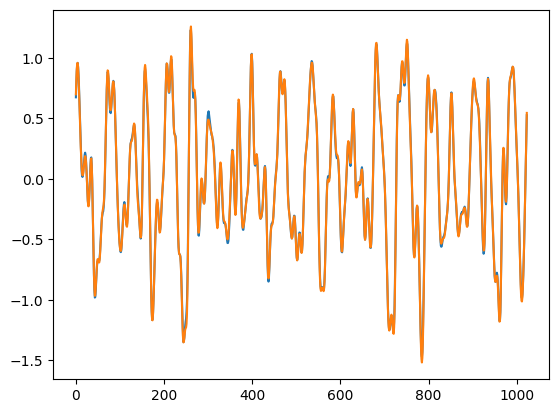

In [ ]:
model = FNO1d(in_channels=1, out_channels=1, width=64, modes=512, depth=3).to(device)
model.load_state_dict(torch.load("best_FNO.pt", map_location=device))
model.eval() 
X_tensor = torch.from_numpy(X_test / std).float().to(device)
y_pred = None
with torch.no_grad():
    y_pred = model(X_tensor)
    y_pred = y_pred.cpu().numpy() * std

print(f"MAE/Hs: {np.mean(np.abs(y_pred[0] - y_test[0]))/Hs[0]*100:.3f}%")

plt.plot(y_pred[100])
plt.plot(y_test[100])